# Variational Autoencoders

In [1]:
import torch


In [2]:
device = torch.device("cuda")
torch.backends.cudnn.benchmark = True
torch.set_num_threads(12)

In [3]:
from deeptime.data import sqrt_model

dtraj, traj = sqrt_model(n_samples=10000)

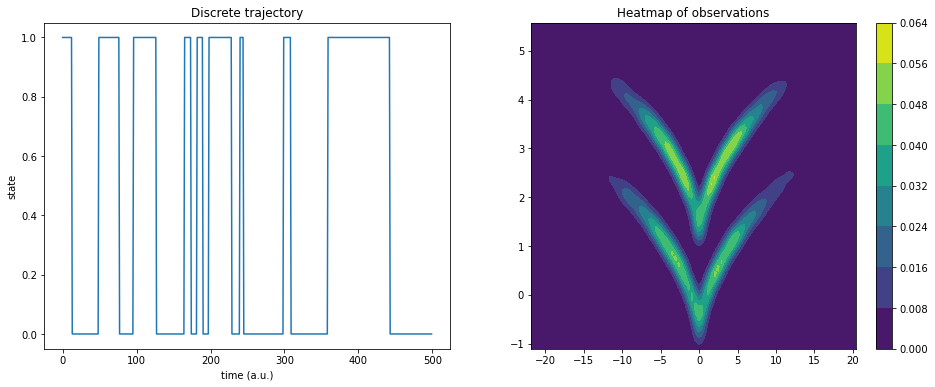

In [4]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

X, Y = np.meshgrid(
    np.linspace(np.min(traj[:, 0]), np.max(traj[:, 0]), 100),
    np.linspace(np.min(traj[:, 1]), np.max(traj[:, 1]), 100),
)
kde_input = np.dstack((X, Y)).reshape(-1, 2)

kernel = stats.gaussian_kde(traj.T, bw_method=.1)
Z = kernel(kde_input.T).reshape(X.shape)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(dtraj[:500])
ax1.set_title('Discrete trajectory')
ax1.set_xlabel('time (a.u.)')
ax1.set_ylabel('state')

cm = ax2.contourf(X, Y, Z)
plt.colorbar(cm, ax=ax2);
ax2.set_title('Heatmap of observations');



In [5]:
from torch.utils.data import DataLoader
from deeptime.util.data import TrajectoryDataset

dataset = TrajectoryDataset(1, traj.astype(np.float32))

n_val = int(len(dataset)*.5)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])

loader_train = DataLoader(train_data, batch_size=64, shuffle=False)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)



In [6]:
# to make life more easy, denoise the data 

In [7]:
import torch
from deeptime.util.torch import MLP

units = [2, 10, 10, 1]
encoder = MLP(units, nonlinearity=torch.nn.ReLU, output_nonlinearity=torch.nn.Sigmoid,
              initial_batchnorm=False)
decoder = MLP(units[::-1], nonlinearity=torch.nn.ReLU, initial_batchnorm=False)



In [8]:
from deeptime.decomposition.deep import TAE

tae = TAE(encoder, decoder, learning_rate=1e-3)
tae.fit(loader_train, n_epochs=30, validation_loader=loader_val)
tae_model = tae.fetch_model()



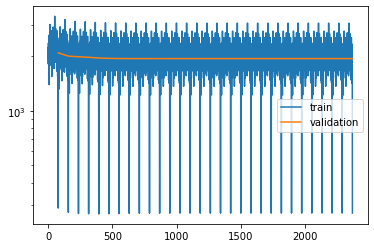

In [9]:
plt.semilogy(*tae.train_losses.T, label='train')
plt.semilogy(*tae.validation_losses.T, label='validation')
plt.legend();

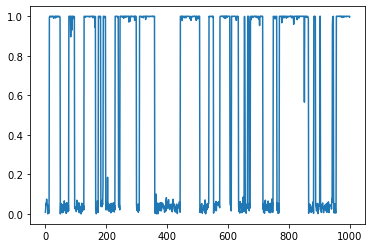

In [10]:
proj = tae_model.transform(traj)
plt.plot(proj[:1000])

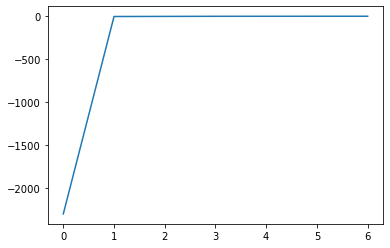

In [11]:
from sklearn.cluster import KMeans
random_state = 42
scores = []
for i in range(1, 7+1):
    clf = KMeans(n_clusters=i, random_state=random_state).fit(proj)
    scores.append(clf.score(proj))
plt.plot(scores)
plt.show()

# Now real data

In [49]:
import pandas as pd
#time_ser = pd.read_json("Trajectories/ZIKV/ZIKV-Pro-427-1_dynophore_time_series.json")
time_ser = pd.read_json("Trajectories/1KE7_dynophore_time_series.json")
time_ser = time_ser.drop(columns="num_frames")
obs = time_ser.drop_duplicates()
num_obs = len(obs)
print("There are actually ", num_obs, " present.")
obs = obs.to_numpy()
time_ser = time_ser.to_numpy()
print("The length of the observation sequence is ", len(time_ser))

There are actually  28  present.
The length of the observation sequence is  1001


In [51]:
time_ser.shape

(1001, 10)

In [157]:
dataset = TrajectoryDataset(1, time_ser.astype(np.float32))

n_val = int(len(dataset)*.5)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])
print(len(val_data))
loader_train = DataLoader(train_data, batch_size=64, shuffle=False)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

500


In [158]:
num_superfeatures = len(obs[0])

In [159]:
units = [num_superfeatures, 4*num_superfeatures, 4*num_superfeatures, 1]
encoder = MLP(units, nonlinearity=torch.nn.ReLU, output_nonlinearity=torch.nn.Sigmoid,
              initial_batchnorm=False)
decoder = MLP(units[::-1], nonlinearity=torch.nn.ReLU, initial_batchnorm=False)

In [160]:
tae = TAE(encoder, decoder, learning_rate=1e-3)
tae.fit(loader_train, n_epochs=50, validation_loader=loader_val)
tae_model = tae.fetch_model()


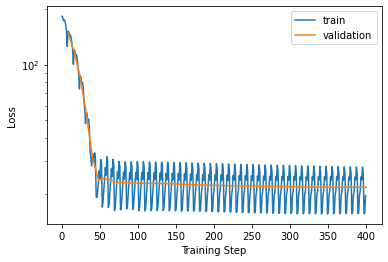

In [161]:
plt.semilogy(*tae.train_losses.T, label='train')
plt.semilogy(*tae.validation_losses.T, label='validation')
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.legend();

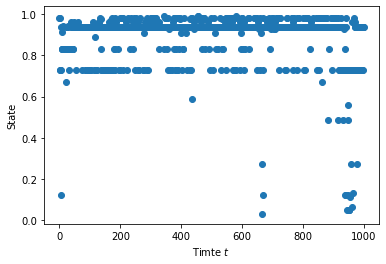

In [165]:
proj = tae_model.transform(time_ser)
plt.ylabel("State")
plt.xlabel("Timte $t$")
plt.scatter(np.arange(0,1000,1), proj[:1000])


# Cluster for Distinct States

In [61]:
from sklearn.cluster import KMeans
from tqdm import tqdm
random_state = 42
scores = np.zeros(16)
sum_of_squared_distances = np.zeros(16)
for i in range(1, 15):
    clf = KMeans(n_clusters=i, random_state=random_state).fit(proj)
    scores[i] = clf.score(proj)
    sum_of_squared_distances[i] = clf.inertia_

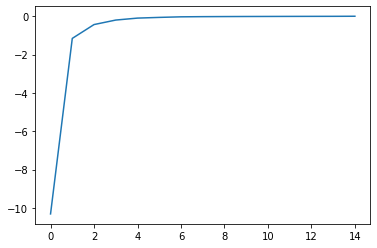

In [62]:
plt.plot(scores[1:])

In [63]:
len(np.unique(proj))
metric = np.diff(sum_of_squared_distances[1:]/sum_of_squared_distances[1:][0])

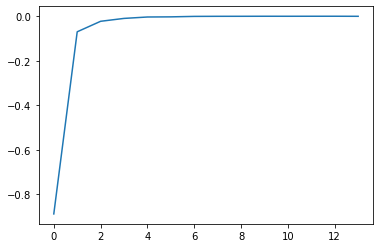

In [64]:
plt.plot(np.diff(sum_of_squared_distances[1:]/sum_of_squared_distances[1:][0]))

In [65]:
metric

array([-8.87921287e-01, -6.99933209e-02, -2.28132408e-02, -9.87182944e-03,
       -3.55935915e-03, -2.91052209e-03, -8.38179303e-04, -4.59080793e-04,
       -3.84285749e-04, -2.00908792e-04, -2.69653744e-04, -1.95257340e-04,
       -1.59033698e-04, -4.24040651e-04])

(array([  2,   3,   4,   6,  21,  55,  73,  84,  92,  98, 101, 103, 115,
       121, 122, 138, 141, 142, 143, 146, 147, 148, 155, 156, 157, 166,
       169, 174, 177, 181, 195, 199, 210, 221, 248, 259, 262, 275, 276,
       289, 291, 355, 364, 368, 379, 385, 390, 402, 420, 427, 432, 493,
       504, 530, 546, 569, 574, 579, 594, 607, 649, 658, 667, 668, 721,
       741, 743, 766, 779, 802, 806, 847, 852, 862, 896, 917, 918, 926,
       928, 934, 935, 936, 940, 942, 943, 945, 947, 948, 952, 953, 954,
       956, 958, 960, 962, 963, 964, 965, 966, 967, 972, 975, 976, 977,
       979, 980, 981, 982, 983, 987, 992, 995]),)
[False False  True ... False False False]


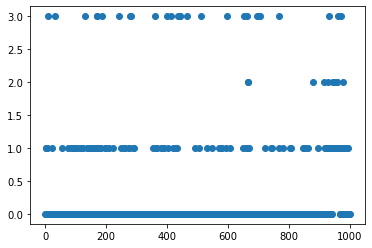

In [129]:
#get labels
clf = KMeans(n_clusters=4, random_state=random_state).fit(proj)
labels = clf.labels_
plt.scatter(np.arange(0, len(time_ser),1),labels)
print(np.where(labels.astype(int) == 1))
print(labels==1)

In [128]:
print(labels[31])

0


# Fit MSM to Discretization

For HMM see: https://deeptime-ml.github.io/latest/api/generated/deeptime.markov.hmm.BayesianHMMPosterior.html#deeptime.markov.hmm.BayesianHMMPosterior

In [99]:
import numpy as np
from deeptime.markov import TransitionCountEstimator

estimator = TransitionCountEstimator(
    lagtime=1,
    count_mode="sliding"
)


In [100]:
counts = estimator.fit(labels).fetch_model()  # fit and fetch the model

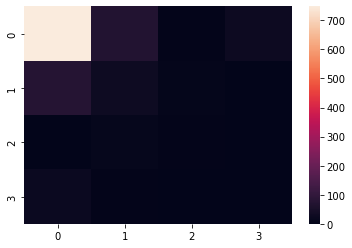

In [101]:
import seaborn as sns
ax = sns.heatmap(counts.count_matrix)

In [102]:
import deeptime.markov as markov

estimator = markov.msm.MaximumLikelihoodMSM(
    reversible=True,
    stationary_distribution_constraint=None
)

msm = estimator.fit(counts).fetch_model()

In [103]:
print("Estimated transition matrix:", msm.transition_matrix)
print("Estimated stationary distribution:", msm.stationary_distribution)

Estimated transition matrix: [[0.88311688 0.0850059  0.00354191 0.0283353 ]
 [0.64285714 0.25892857 0.07142857 0.02678571]
 [0.21428571 0.57142857 0.21428571 0.        ]
 [0.88888889 0.11111111 0.         0.        ]]
Estimated stationary distribution: [0.847 0.112 0.014 0.027]


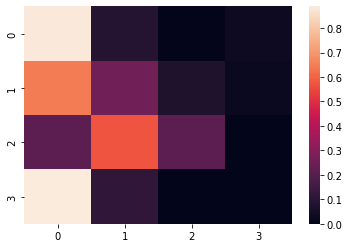

In [104]:
ax = sns.heatmap(msm.transition_matrix)

# Fit HMM to Discretization & Raw Data

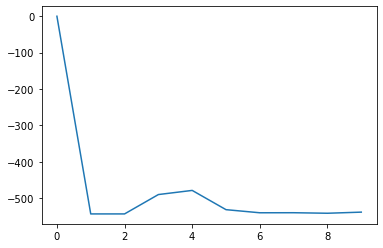

In [74]:
from hmmlearn import hmm
from sklearn.preprocessing import LabelEncoder
def calculate_probas(time_ser, model): 
    probas = model.predict_proba(time_ser)
    states = model.predict(time_ser)
    return np.mean(np.linalg.norm(probas, axis=1))


num_sim = 10
scores = np.zeros(num_sim)
probas = np.zeros(num_sim)
labels = labels.reshape(-1, 1)
for i in range(1,num_sim):
    model = hmm.MultinomialHMM(n_components=i)
    try:
        pred = model.fit(labels)
        scores[i] = model.score(labels)
        probas[i] = calculate_probas(time_ser, model)
    except: 
        scores[i] = 0
        probas[i] = 0
plt.cla()
plt.clf()
plt.plot(scores)

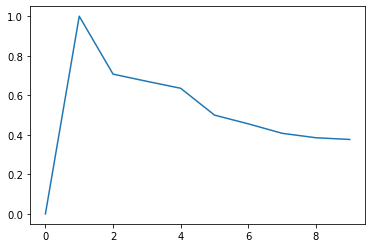

In [77]:
plt.plot(probas)

In [93]:
def proba_per_state(time_ser, model): 
    """
    """
    probas = model.predict_proba(time_ser)
    states = model.predict(time_ser)
    prob_ser = np.zeros(probas.shape)
    for i in range(len(states)):
        prob_ser[i, states[i]] = probas[i, states[i]]
    return prob_ser 
model = hmm.MultinomialHMM(n_components=4)
labels = labels.reshape(-1, 1)
model.fit(labels)
result = model.predict(labels)
print(labels[:10])
test = proba_per_state(labels, model)[:2000]
    

[[0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [3]
 [0]]


In [94]:
probas = model.predict_proba(labels)

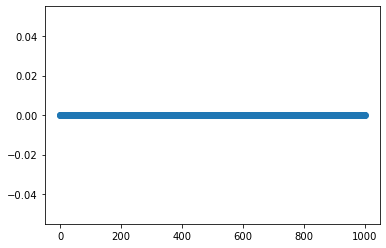

In [95]:
plt.scatter(np.arange(0, len(test),1),test[:,0])

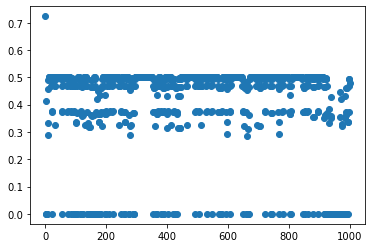

In [96]:
plt.scatter(np.arange(0, len(test),1),test[:,1])

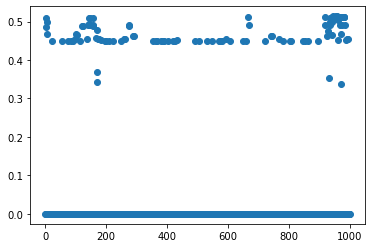

In [97]:
plt.scatter(np.arange(0, len(test),1),test[:,2])

In [83]:
def aic(scores):
    return -2*scores -2*np.arange(1,11,1)

In [84]:
aic = aic(scores)

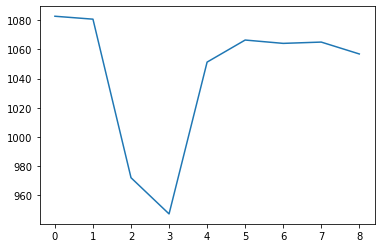

In [85]:
plt.plot(aic[1:])

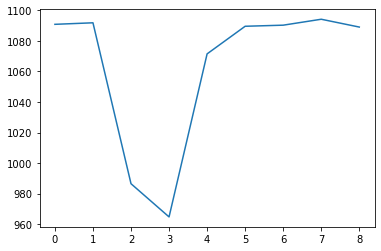

In [86]:
def bic(scores): 
    return -2*scores +np.arange(1,11,1)+np.log(len(scores))
bic = bic(scores)
plt.plot(bic[1:])

In [87]:
probas = model.predict_proba(time_ser)
np.mean(np.linalg.norm(probas, axis=1))

0.42476247139256523

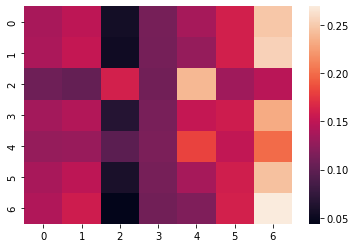

In [88]:
ax=sns.heatmap(model.transmat_)

# HMM on the whole trajectory

In [89]:
def label_traj(time_ser, obs):
    reduced_time_ser = np.zeros(len(time_ser))
    for i in range(len(time_ser)):
        for j in range(len(obs)):
            if compare_array(time_ser[i], obs[j]): 
                reduced_time_ser[i] = j
                break
    return reduced_time_ser.astype(np.int64)

def compare_array(arr1, arr2): 
    comp = arr1 == arr2 
    return comp.all()
red_time_ser = label_traj(time_ser, obs)

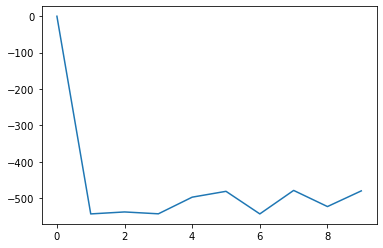

In [90]:
from hmmlearn import hmm
from sklearn.preprocessing import LabelEncoder
def calculate_probas(time_ser, model): 
    probas = model.predict_proba(time_ser)
    states = model.predict(time_ser)
    return np.mean(np.linalg.norm(probas, axis=1))


num_sim = 10
scores = np.zeros(num_sim)
probas = np.zeros(num_sim)
labels = labels.reshape(-1, 1)
for i in range(1,num_sim):
    model = hmm.MultinomialHMM(n_components=i)
    try:
        pred = model.fit(labels)
        scores[i] = model.score(labels)
        probas[i] = calculate_probas(time_ser, model)
    except: 
        scores[i] = 0
        probas[i] = 0
plt.cla()
plt.clf()
plt.plot(scores)

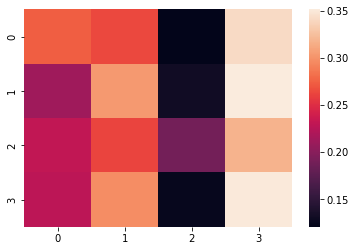

In [92]:
model = hmm.MultinomialHMM(n_components=4)
red_time_ser = red_time_ser.reshape(-1, 1)
model.fit(red_time_ser)
result = model.predict(red_time_ser)
ax=sns.heatmap(model.transmat_)